#### reference article: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

After starting this project, I realized I didn't know much about working with time series data.  This is side research that didn't end up being applicable to my final models.

In [159]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [134]:
df=pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')

In [135]:
df=pd.merge(data, labels, on=['city', 'year', 'weekofyear'])

In [136]:
df['week_start_date']=pd.to_datetime(df['week_start_date'])
df['month']=df['week_start_date'].dt.month
### reset axis
df.index = df['week_start_date']
del df['week_start_date']

iq=df[df['city']=='iq']
sj=df[df['city']=='sj']

In [8]:
iq.fillna(method='ffill', inplace=True)
sj.fillna(method='ffill', inplace=True)

### Check Stationarity of Time Series
- constant mean
- constant variance
- an autocovariance that does not depend on time

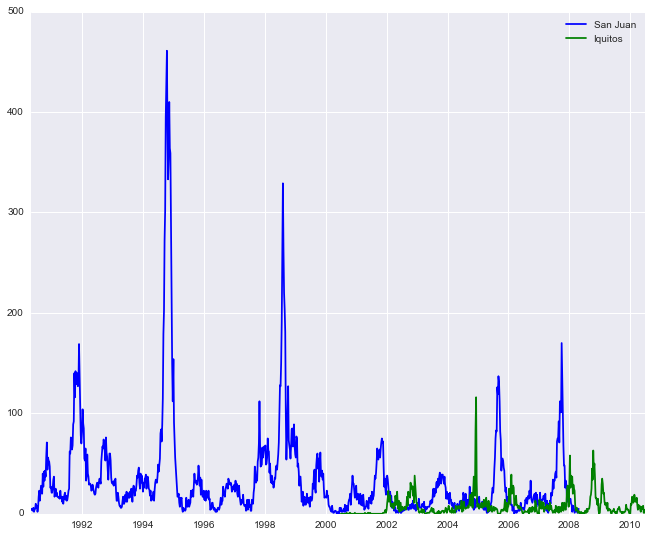

In [160]:
plt.figure(figsize=(11,9))
plt.plot(sj['total_cases'],label="San Juan", color='b')
plt.plot(iq['total_cases'],label="Iquitos", color='g')
plt.legend()

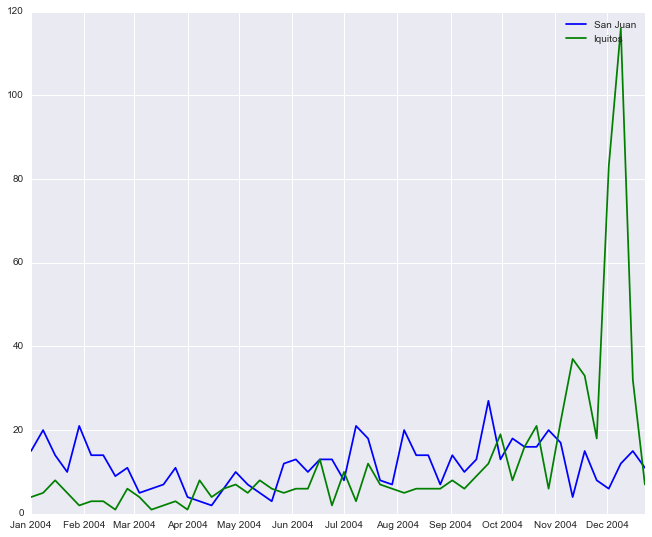

In [162]:
#randomly plot one year only - 2004 
plt.figure(figsize=(11,9))
plt.plot(sj['2004']['total_cases'],label="San Juan", color='b')
plt.plot(iq['2004']['total_cases'],label="Iquitos", color='g')
plt.legend()


In [142]:
# not stationary
# no clear increase throughout the years (1990-2010)
# no clear increase throughout the months (jan - dec)
# the outbreaks in the disease dont appear to be dependent on the time stamp-
# it's more the mechanics of how the disease spreads through people and networks, and the contagiousness of dengue

In [143]:
#a look into rolling mean and std and the Dickey_Fuller test 

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=3)#three month rolling avg
    rolstd = pd.rolling_std(timeseries, window=3)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

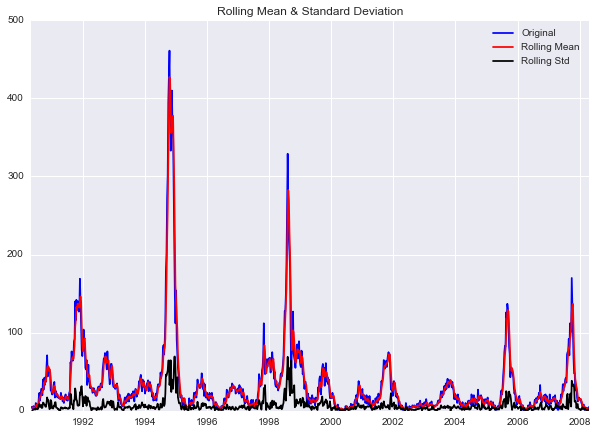

Results of Dickey-Fuller Test:
Test Statistic                -6.650078e+00
p-value                        5.147319e-09
#Lags Used                     9.000000e+00
Number of Observations Used    9.260000e+02
Critical Value (10%)          -2.568435e+00
Critical Value (1%)           -3.437432e+00
Critical Value (5%)           -2.864666e+00
dtype: float64


In [165]:
plt.figure(figsize=(10,7))
test_stationarity(sj['total_cases'])

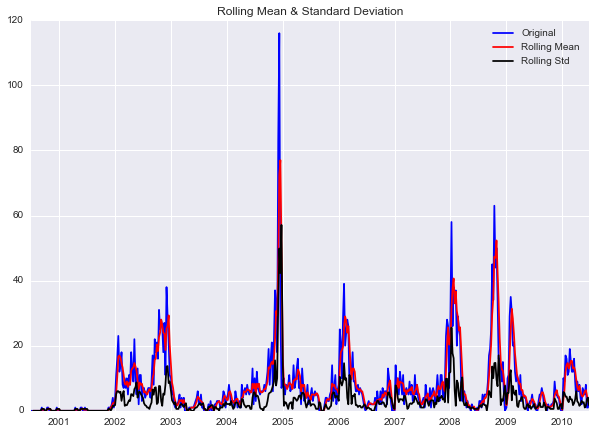

Results of Dickey-Fuller Test:
Test Statistic                -6.085429e+00
p-value                        1.067252e-07
#Lags Used                     4.000000e+00
Number of Observations Used    5.150000e+02
Critical Value (10%)          -2.569768e+00
Critical Value (1%)           -3.443112e+00
Critical Value (5%)           -2.867168e+00
dtype: float64


In [166]:
plt.figure(figsize=(10,7))
test_stationarity(iq['total_cases'])

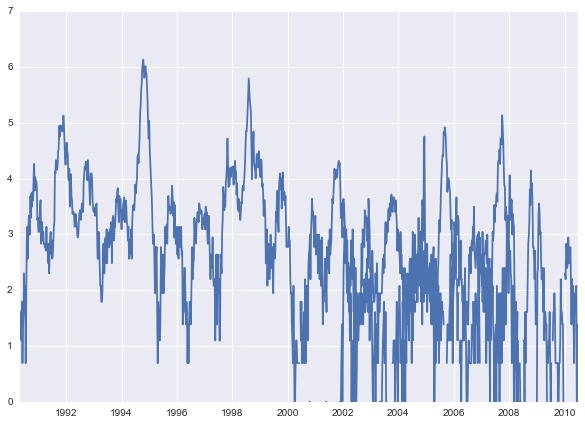

In [167]:
#plot the log of the total cases
plt.figure(figsize=(10,7))
ts_log = np.log(df['total_cases'])
plt.plot(ts_log)

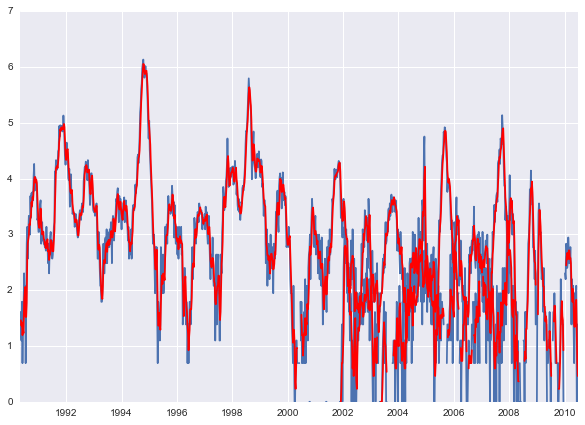

In [168]:
#plot 3 week rolling mean of the log
plt.figure(figsize=(10,7))
moving_avg = pd.rolling_mean(ts_log,3)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [148]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

week_start_date
1990-04-30         NaN
1990-05-07         NaN
1990-05-14   -0.074381
1990-05-21   -0.266169
1990-05-28    0.366204
1990-06-04   -0.501359
1990-06-11    0.095894
1990-06-18    0.379811
1990-06-25    0.536479
1990-07-02   -0.109501
1990-07-09    0.021513
1990-07-16   -0.828302
Name: total_cases, dtype: float64

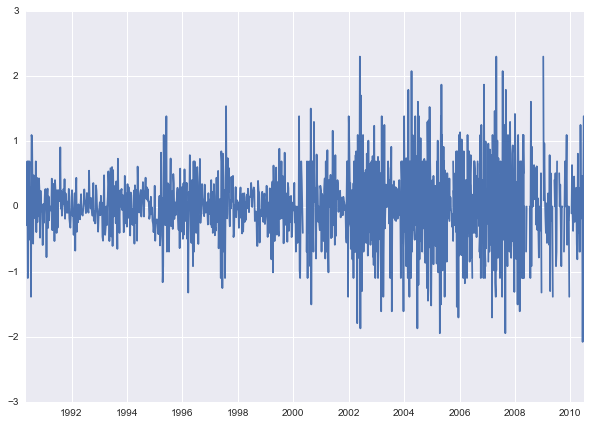

In [169]:
#differencing
plt.figure(figsize=(10,7))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [150]:
#pretty cool - hope to take a class on timeseries analytics in the future

In [151]:
ts_log.replace([np.inf, -np.inf], np.nan)
ts_log.dropna(inplace=True)

In [152]:
ts_log=ts_log+1

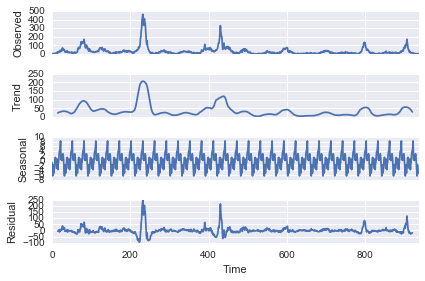

In [177]:
#print decomposition of the time series
import statsmodels.api as sm

#decomposition = seasonal_decompose(ts_log.price.values, freq=30)
# deal with missing values. see issue
sj.total_cases.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(sj.total_cases.values, freq=30)
resplot = res.plot()

## forecasting using ARIMA

In [179]:
#need floats for this to work
sj['total_cases']=sj['total_cases'].astype(float)
iq['total_cases']=iq['total_cases'].astype(float)

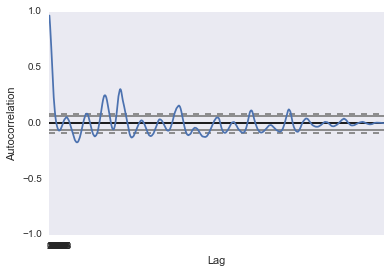

In [185]:
#from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot #keep consistent with the tutorial
from pandas.tools.plotting import autocorrelation_plot

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = sj['total_cases']
autocorrelation_plot(series)

pyplot.xticks(np.arange(0, 50, 1.0))
pyplot.show()

In [186]:
from statsmodels.tsa.arima_model import ARIMA
#import pandas as pd
from pandas import DataFrame

                             ARIMA Model Results                              
Dep. Variable:          D.total_cases   No. Observations:                  935
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -3752.129
Method:                       css-mle   S.D. of innovations             13.383
Date:                Thu, 04 May 2017   AIC                           7520.257
Time:                        23:38:56   BIC                           7558.981
Sample:                    05-07-1990   HQIC                          7535.023
                         - 04-22-2008                                         
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                   0.0024      0.638      0.004      0.997        -1.249     1.254
ar.L1.D.total_cases     0.1197      0.033      3.663      0.000         0.056     0.184
ar.L2.D.total_ca

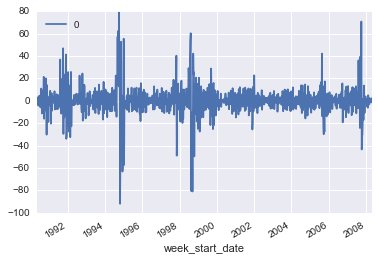

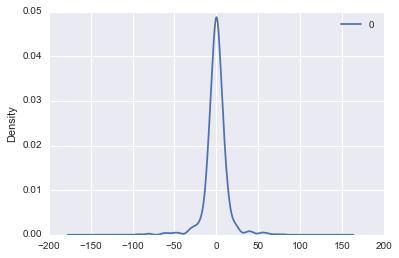

                0
count  935.000000
mean    -0.000124
std     13.390251
min    -92.041002
25%     -4.876123
50%      0.196275
75%      5.244900
max     78.661745


In [187]:
model = ARIMA(series, order=(6,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [71]:
# df=pd.read_csv('dengue_features_train.csv')
# labels = pd.read_csv('dengue_labels_train.csv')
# test = pd.read_csv('dengue_features_test.csv')
# submission=pd.read_csv('submission_format.csv')

In [72]:
# df['week_start_date']=pd.to_datetime(df['week_start_date'])
# test['week_start_date']=pd.to_datetime(test['week_start_date'])

# df=pd.merge(data, labels, on=['city', 'year', 'weekofyear'])
# ### reset axis
# df.index = df['week_start_date']
# del df['week_start_date']

# test.index = test['week_start_date']
# del test['week_start_date']

# iq=df[df['city']=='iq']
# sj=df[df['city']=='sj']

# iq_test=test[test['city']=='iq']
# sj_test=test[test['city']=='sj']

In [75]:
# sj['total_cases']=sj['total_cases'].astype(float)
# iq['total_cases']=iq['total_cases'].astype(float)

Test MSE: 4.587


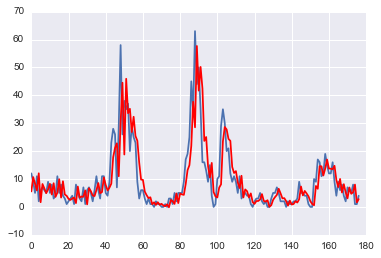

In [191]:
from sklearn.metrics import mean_absolute_error

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series1 = sj['total_cases']

X = series.values
#size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [189]:
#check how far in the future to forecast
print(len(sj_test))
print(len(iq_test))

260
156


In [60]:
#get the forecast for San Juan
sj_forecast= model_fit.forecast(260)

Test MSE: 4.587


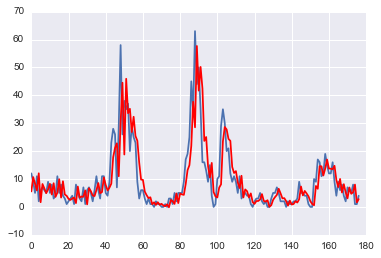

In [190]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = iq['total_cases']

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [102]:
#get forecast for Iquitos
iq_forecast= model_fit.forecast(156)
len(iq_forecast[0])

156

In [104]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_forecast[0], iq_forecast[0]])
submission.to_csv("submissions/arima.csv")

### cool stuff but the model cannot predict that far into the future (decades) and be accurate, so I can't include these predictions in future analysis